In [1]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.set(font_scale=1.2)

# Определение перспективного тарифа для телеком-компании

- [Описание проекта](#project_description)
- [Загрузка и подготовка данных к анализу](#data_upload_and_preparation)
- [Анализ данных](#data_analysis)
    - [Минуты разговора](#calls)
    - [Количество отправленных сообщений](#messages)
    - [Объем интенет-трафика](#internet)
    - [Выручка](#revenue)
- [Проверка гипотез](#hypothesis_testing)
    - [Средняя выручка пользователей тарифов smart и ultra различаются](#hypothesis_1)
    - [Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#hypothesis_2)
- [Общий вывод](#conclusion)

## Описание проекта <a name='project_description'></a>

Компания «Мегалайн» – федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

## Загрузка и подготовка данных к анализу <a name='data_upload_and_preparation'></a>

Данные предоставлены за 2018 год.

In [2]:
users = pd.read_csv('datasets/users.csv')
users = users.rename(columns={'tariff': 'tariff_name'})
tariffs = pd.read_csv('datasets/tariffs.csv')
calls = pd.read_csv('datasets/calls.csv')
messages = pd.read_csv('datasets/messages.csv')
internet = pd.read_csv('datasets/internet.csv', index_col=0)

<br>

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      500 non-null    int64 
 1   age          500 non-null    int64 
 2   churn_date   38 non-null     object
 3   city         500 non-null    object
 4   first_name   500 non-null    object
 5   last_name    500 non-null    object
 6   reg_date     500 non-null    object
 7   tariff_name  500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Приведем столбцы `reg_date` и `churn_date` к типу `datetime`.

In [5]:
for col in ['reg_date', 'churn_date']:
    users[col] = pd.to_datetime(users[col])

In [6]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переведем объём интернет-трафика, включённого в абонентскую плату, из мегабайт в гигабайты.

In [7]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] // 1024
tariffs = tariffs.drop(columns=['mb_per_month_included'])

In [8]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Приведем столбец `call_date` к типу `datetime`.

In [10]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

Округлим длительность звонка в бо́льшую сторону.

In [11]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [12]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Приведем столбец `message_date` к типу `datetime`.

In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [15]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Приведем столбец `session_date` к типу `datetime`.

In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

<br>

Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам

In [18]:
user_calls_by_month = (
    calls
    .groupby(['user_id', calls['call_date'].dt.month_name()])
    .agg({'id': 'count', 'duration': 'sum'})
    .reset_index()
    .rename(columns={'call_date': 'month', 'id': 'calls_count', 'duration': 'calls_duration'})
)

user_calls_by_month

,user_id,month,calls_count,calls_duration
0,1000,August,52,408
1,1000,December,46,333
2,1000,July,47,340
3,1000,June,43,172
4,1000,May,22,159
...,...,...,...,...
3169,1498,September,59,471
3170,1499,December,69,492
3171,1499,November,74,612
3172,1499,October,68,449


* количество отправленных сообщений по месяцам

In [19]:
user_messages_by_month = (
    messages
    .groupby(['user_id', messages['message_date'].dt.month_name()])
    .agg({'id': 'count'})
    .reset_index()
    .rename(columns={'message_date': 'month', 'id': 'messages_count'})
)

user_messages_by_month

,user_id,month,messages_count
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22
...,...,...,...
2712,1498,September,44
2713,1499,December,66
2714,1499,November,59
2715,1499,October,48


* объем израсходованного интернет-трафика по месяцам

In [20]:
user_internet_by_month = (
    internet
    .groupby(['user_id', internet['session_date'].dt.month_name()])
    .agg({'mb_used': lambda x: int(np.ceil(sum(x) / 1024))})
    .reset_index()
    .rename(columns={'session_date': 'month', 'mb_used': 'gb_used'})
)

user_internet_by_month

,user_id,month,gb_used
0,1000,August,14
1,1000,December,10
2,1000,July,14
3,1000,June,23
4,1000,May,3
...,...,...,...
3198,1498,September,22
3199,1499,December,13
3200,1499,November,18
3201,1499,October,18


* помесячную выручку с каждого пользователя

In [21]:
def get_revenue(info):
    total_fee = info['rub_monthly_fee']
    total_fee += max(info['rub_per_minute'] * (info['calls_duration'] - info['minutes_included']), 0) \
               + max(info['rub_per_message'] * (info['messages_count'] - info['messages_included']), 0) \
               + max(info['rub_per_gb'] * (info['gb_used'] - info['gb_per_month_included']), 0)
    return total_fee


users_monthly_info = (
    user_calls_by_month[['user_id', 'month', 'calls_duration']]
    .merge(user_messages_by_month, on=['user_id', 'month'], how='outer')
    .merge(user_internet_by_month, on=['user_id', 'month'], how='outer')
    .fillna(0)
    .merge(users[['user_id', 'tariff_name']], on='user_id')
    .merge(tariffs, on='tariff_name')
)

users_monthly_info['revenue'] = users_monthly_info.apply(get_revenue, axis=1)

users_monthly_revenue = users_monthly_info[['user_id', 'month', 'revenue']]
users_monthly_revenue

,user_id,month,revenue
0,1000,August,1950.0
1,1000,December,1950.0
2,1000,July,1950.0
3,1000,June,1950.0
4,1000,May,1950.0
...,...,...,...
3209,1489,August,550.0
3210,1489,December,950.0
3211,1489,November,1150.0
3212,1489,October,1550.0


## Анализ данных <a name='data_analysis'></a>

In [22]:
def plot_hists(df, col, label, by, suptitle):
    df = df.merge(users[['user_id', by]], on='user_id')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
    for i, (by_name, fc) in enumerate(zip(df[by].unique(), np.array(sns.color_palette('Paired'))[[6, 8]])):
        values = df.loc[df[by] == by_name, col]
        median, mean = values.agg(['median', 'mean'])
        sns.histplot(
            values,
            stat='density',
            bins=int(1.72 * (len(values))**(1/3)),
            ax=ax[i],
            color=fc
        )
        patches = ax[i].patches
        bin_edges = np.array([patch.get_x() for patch in patches])
        ax[i].vlines(x=median, ymin=0, ymax=patches[np.argmax(bin_edges > median) - 1].get_height(), color='green', label='медиана')
        ax[i].vlines(x=mean, ymin=0, ymax=patches[np.argmax(bin_edges > mean) - 1].get_height(), color='red', label='среднее')
        ax[i].set_xlabel(label)
        ax[i].set_ylabel('Плотность частоты')
        ax[i].set_title(by_name)
        ax[i].legend()
    plt.suptitle(suptitle)
    plt.show()

In [23]:
def get_col_statistics(df, col, by):
    df = df.merge(users[['user_id', by]], on='user_id')
    statistics = df.groupby(by)[col].describe().round(2)
    return statistics                   

In [24]:
def get_col_above_tariff_statistics(df, col, col_included):
    df = (
        df
        .merge(users[['user_id', 'tariff_name']], on='user_id')
        .merge(tariffs, on='tariff_name')
    )
    abobe_tariff_statistics = pd.DataFrame()
    for name, group in df.groupby(['tariff_name', col_included]):
        tariff_name, included = name
        above_tariff = round(100 - percentileofscore(df.loc[df['tariff_name'] == tariff_name, col], included), 1)
        abobe_tariff_statistics = abobe_tariff_statistics.append({
            'tariff': tariff_name,
            col_included: included,
            'above_tariff %': above_tariff
        }, ignore_index=True)
    return abobe_tariff_statistics

In [25]:
def make_monthly_barplot_by_tariff(df, col, label, title):
    df = df.merge(users[['user_id', 'tariff_name']], on='user_id')
    months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
    df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)
    df = df.sort_values(['month', 'tariff_name'])
    
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(
        x='month', y=col,
        data=df,
        hue='tariff_name',
        errorbar=None,
        palette='Set2'
    )
    ax.set_xlabel('Месяц')
    ax.set_ylabel(label)
    ax.set_title(title)
    plt.legend(title='Тариф')

### Минуты разговора <a name='calls'></a>

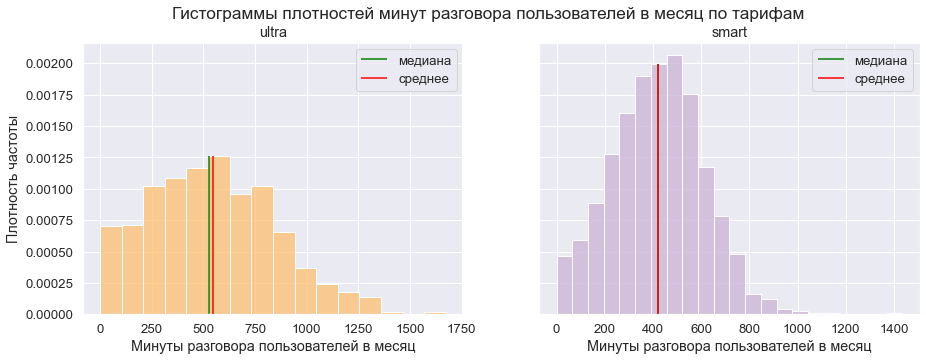

In [26]:
plot_hists(
    user_calls_by_month,
    'calls_duration', 
    'Минуты разговора пользователей в месяц',
    'tariff_name',
    'Гистограммы плотностей минут разговора пользователей в месяц по тарифам'
)

In [27]:
get_col_statistics(user_calls_by_month, 'calls_duration', 'tariff_name')

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2223.0,419.06,189.33,0.0,285.0,423.0,545.5,1435.0
ultra,951.0,545.45,306.93,0.0,310.0,528.0,756.5,1673.0


In [28]:
get_col_above_tariff_statistics(user_calls_by_month, 'calls_duration', 'minutes_included')

,tariff,minutes_included,above_tariff %
0,smart,500.0,34.0
1,ultra,3000.0,0.0


* Распределение по smart-тарифу более-менее симметрично. Распределение по ultra-тарифу скошено вправо

* У тарифа ultra медиана, среднее и стандартное отклонение больше

* По тарифу smart 34% пользований с дополнительными минутами разговора. По тарифу ultra такого не наблюдается, так как у него в 6 раз больше включенных минут. Максимальное время разговора в 2 раза меньше, чем включено

* Нулевые по продолжительности звонки являются пропущенным

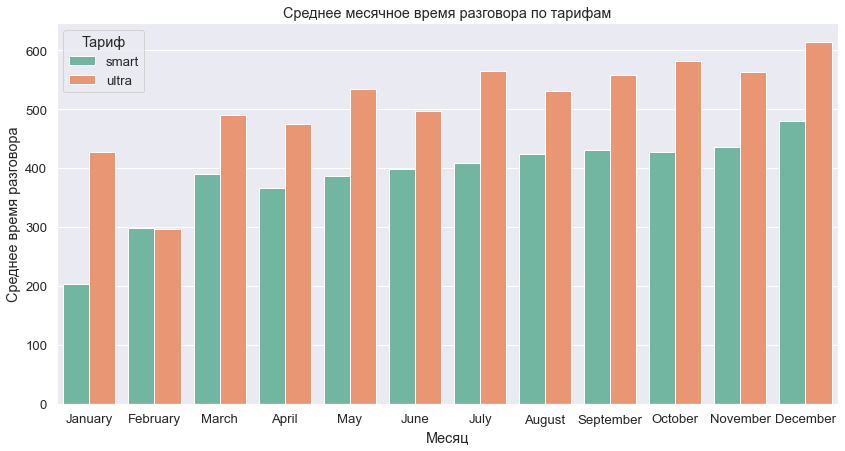

In [29]:
make_monthly_barplot_by_tariff(
    user_calls_by_month, 
    'calls_duration',
    'Среднее время разговора',
    'Среднее месячное время разговора по тарифам'
)

* В феврале по тарифу ultra среднее время разговора сильно снизилось

* Есть положительный тренд среднего времени разговора по обоим тарифам

### Количество отправленных сообщений <a name='messages'></a>

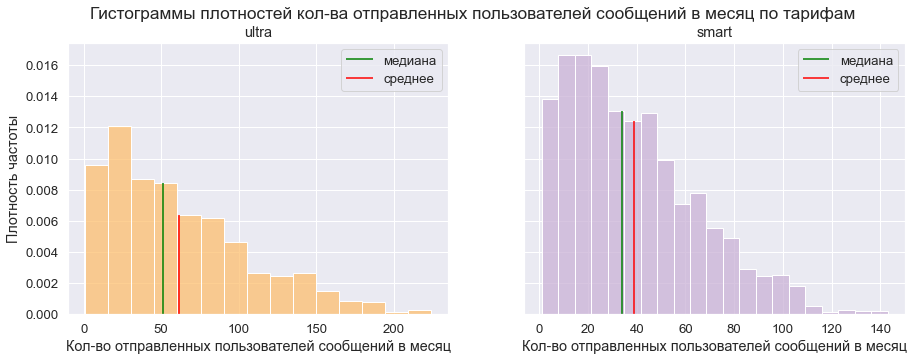

In [30]:
plot_hists(
    user_messages_by_month,
    'messages_count', 
    'Кол-во отправленных пользователей сообщений в месяц',
    'tariff_name',
    'Гистограммы плотностей кол-ва отправленных пользователей сообщений в месяц по тарифам'
)

In [31]:
get_col_statistics(user_messages_by_month, 'messages_count', 'tariff_name')

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,1922.0,38.72,26.79,1.0,17.0,34.0,55.0,143.0
ultra,795.0,61.16,45.93,1.0,24.0,51.0,87.5,224.0


In [32]:
get_col_above_tariff_statistics(user_messages_by_month, 'messages_count', 'messages_included')

,tariff,messages_included,above_tariff %
0,smart,50.0,29.8
1,ultra,1000.0,0.0


* Оба распределения скошены вправо

* Медиана, среднее и стандартное отклонение больше у тарифа ultra

* По тарифу smart около 30% пользований превышают лимит по количеству отправленных сообщений. Как и с минутами разговора у тарифа smart не такие щедрые условия

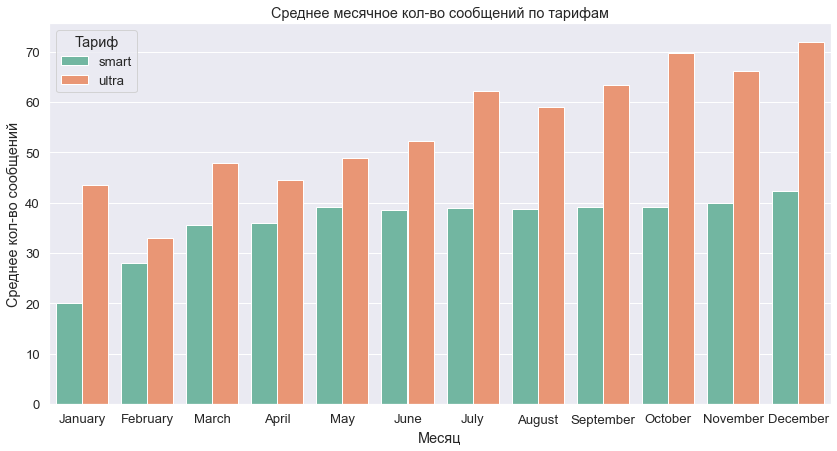

In [33]:
make_monthly_barplot_by_tariff(
    user_messages_by_month, 
    'messages_count',
    'Среднее кол-во сообщений',
    'Среднее месячное кол-во сообщений по тарифам'
)

* В феврале по тарифу ultra также сильно снизилось среднее количество сообщений

* У smart-тарифа среднее количество сообщений особо не менялось с мая по ноябрь

* В основном динамика среднего количества сообщений положительная по обоим тарифам

### Объем интенет-трафика <a name='internet'></a>

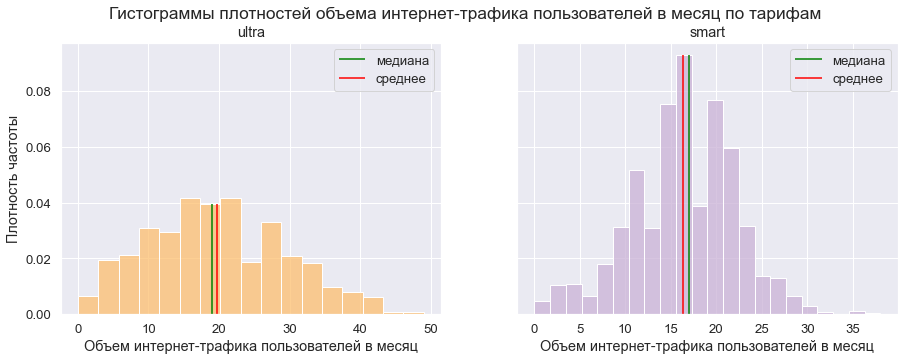

In [34]:
plot_hists(
    user_internet_by_month,
    'gb_used', 
    'Объем интернет-трафика пользователей в месяц',
    'tariff_name',
    'Гистограммы плотностей объема интернет-трафика пользователей в месяц по тарифам'
)

In [35]:
get_col_statistics(user_internet_by_month, 'gb_used', 'tariff_name')

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2228.0,16.34,5.74,0.0,13.0,17.0,20.0,38.0
ultra,975.0,19.69,9.70,0.0,12.0,19.0,27.0,49.0


In [36]:
get_col_above_tariff_statistics(user_internet_by_month, 'gb_used', 'gb_per_month_included')

,tariff,gb_per_month_included,above_tariff %
0,smart,15.0,61.7
1,ultra,30.0,14.6


* Оба распределения симметричны

* По тарифу ultra медиана, среднее и стандартное отклонение больше, чем по тарифу smart

* По обоим тарифам интернет используется сверх пакета. По smart это происходит слишком часто – 2/3 всех выплат

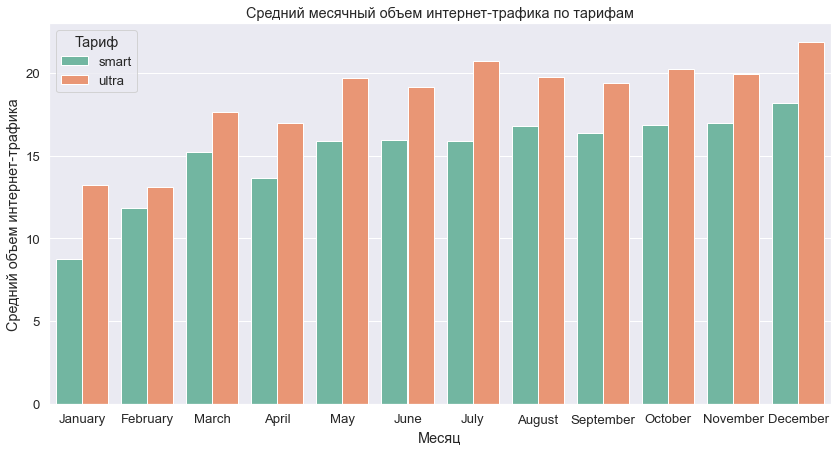

In [37]:
make_monthly_barplot_by_tariff(
    user_internet_by_month, 
    'gb_used',
    'Средний объем интернет-трафика',
    'Средний месячный объем интернет-трафика по тарифам'
)

* В феврале по тарифу ultra на этот раз пользование услугой не поменялось

* В течение года средний объем интернет-трафика в основном увеличивается по обоим тарифам 

#### Выводы по услугам

* У всех видов услуг меры центральной тенденции и разброса больше у тарифа ultra

* По тарифу smart каждый вид услуги периодически использовали сверх пакета, по тарифу ultra только интернет

* Предоставленные минуты разговора и количество сообщений в тарифе ultra не используются в полной мере

* В феврале по тарифу ultra сильно снизилось среднее время разговора и количество сообщений

* В целом наблюдается положительная динамика среднего пользования всеми услугами у обоих тарифов

###  Выручка <a name='revenue'></a>

In [38]:
users['tariff_name'].value_counts(normalize=True)

smart    0.702
ultra    0.298
Name: tariff_name, dtype: float64

Пользователей тарифа smart больше.

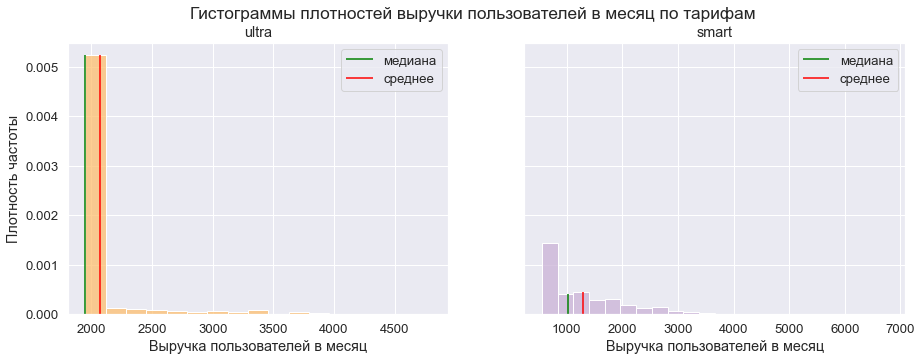

In [39]:
plot_hists(
    users_monthly_revenue,
    'revenue', 
    'Выручка пользователей в месяц',
    'tariff_name',
    'Гистограммы плотностей выручки пользователей в месяц по тарифам'
)

In [40]:
get_col_statistics(users_monthly_revenue, 'revenue', 'tariff_name')

,count,mean,std,min,25%,50%,75%,max
tariff_name,,,,,,,,
smart,2229.0,1289.97,818.40,550.0,550.0,1023.0,1750.0,6770.0
ultra,985.0,2070.15,376.19,1950.0,1950.0,1950.0,1950.0,4800.0


In [41]:
print('Доля выплат, которые больше ежемесячной абонентской платы:')

revenue = (
    users_monthly_revenue
    .merge(users[['user_id', 'tariff_name']], on='user_id')
    .merge(tariffs[['tariff_name', 'rub_monthly_fee']])
)
revenue['within_tariff'] = revenue['revenue'] == revenue['rub_monthly_fee']
1 - revenue.groupby('tariff_name')['within_tariff'].mean()

Доля выплат, которые больше ежемесячной абонентской платы:


tariff_name
smart    0.745626
ultra    0.136041
Name: within_tariff, dtype: float64

* Оба распределения экспоненциальны

* В среднем пользователи тарифа ultra платят немного больше ежемесячной абонентской платы. Средняя ежемесячная плата пользователя smart-тарифа превышает абонентскую в 2 раза

* Разброс выплат сильнее по тарифу smart

* 74% и 13% выплат больше ежемесячной абонентской платы по smart и ultra соответственно

In [42]:
smart_revenue = revenue.loc[revenue['tariff_name'] == 'smart', 'revenue']
ultra_revenue = revenue.loc[revenue['tariff_name'] == 'ultra', 'revenue']

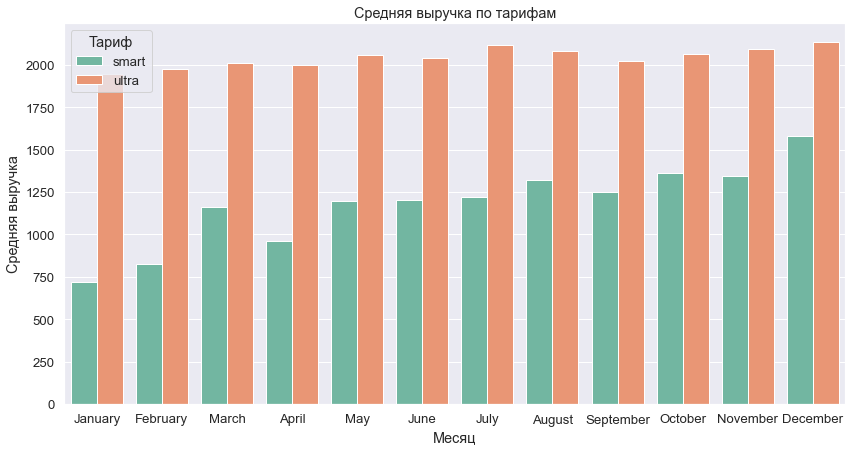

In [43]:
make_monthly_barplot_by_tariff(
    users_monthly_revenue, 
    'revenue',
    'Средняя выручка',
    'Средняя выручка по тарифам'
)

У тарифа ultra средняя выручка по каждому месяцу больше, чем у тарифа smart. Зато средняя выручка ultra-тарифа не так сильно растет как у тарифа smart.

## Проверка гипотез <a name='hypothesis_testing'></a>

### Средняя выручка пользователей тарифов smart и ultra различаются <a name='hypothesis_1'></a>

$H_0: \mu_{smart} = \mu_{ultra}$

$H_1: \mu_{smart} \ne \mu_{ultra}$

In [44]:
cm_by_tariff = CompareMeans(DescrStatsW(smart_revenue), DescrStatsW(ultra_revenue))

_, pvalue, _ = cm_by_tariff.ttest_ind( 
    alternative='two-sided',
    usevar='unequal'
)
print('Двусторонний t-тест для сердних')
print('p-value:', pvalue)
print()

Двусторонний t-тест для сердних
p-value: 4.260631393108093e-250



По сути p-value равно 0, поэтому можем отвергнуть нулевую гипотезу в пользу альтернативной. 

In [45]:
print('Доверительные интервалы разницы средних')
for cl in [0.9, 0.95, 0.99]:
    confidence_interval = tuple(round(bound, 5) for bound in cm_by_tariff.tconfint_diff(alpha=1-cl, usevar='unequal'))
    cl = int(cl * 100)
    print(f'{cl}%: {confidence_interval}')

Доверительные интервалы разницы средних
90%: (-814.85419, -745.50332)
95%: (-821.50074, -738.85677)
99%: (-834.49688, -725.86063)


С 99% вероятностью средняя выручка по smart-тарифу меньше средней выручки по ultra-тарифу на 725-835.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов <a name='hypothesis_2'></a>

$H_0: \mu_{Москва} = \mu_{другие \; регионы}$

$H_1: \mu_{Москва} \ne \mu_{другие \; регионы}$

In [46]:
users['city_category'] = users['city']
users.loc[users['city_category'] != 'Москва', 'city_category'] = 'другой регион'

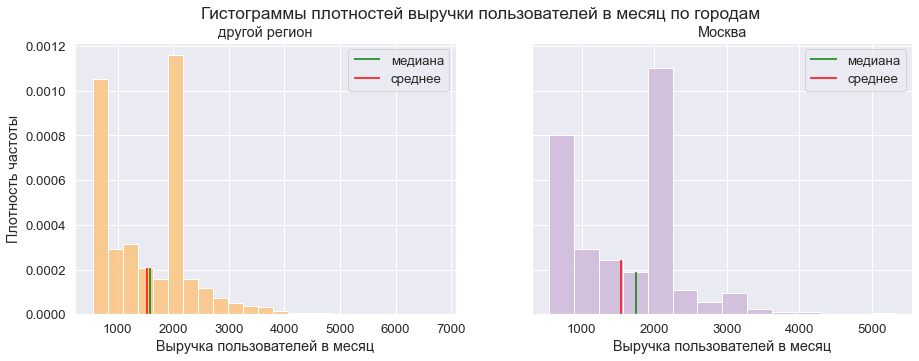

In [47]:
plot_hists(
    users_monthly_revenue,
    'revenue', 
    'Выручка пользователей в месяц',
    'city_category',
    'Гистограммы плотностей выручки пользователей в месяц по городам'
)

In [48]:
get_col_statistics(users_monthly_revenue, 'revenue', 'city_category')

,count,mean,std,min,25%,50%,75%,max
city_category,,,,,,,,
Москва,611.0,1546.71,752.09,550.0,780.5,1750.0,1950.0,5321.0
другой регион,2603.0,1524.94,808.79,550.0,750.0,1583.0,1950.0,6770.0


Похожие экспоненциальные распределения с пиками у ежемесячных абонентских выплат в 550 и 1950.

In [49]:
revenue = users_monthly_revenue.merge(users[['user_id', 'tariff_name', 'city_category']], on='user_id')
moscow_revenue = revenue.loc[revenue['city_category'] == 'Москва', 'revenue']
other_regions_revenue = revenue.loc[revenue['city_category'] == 'другой регион', 'revenue']

In [50]:
cm_by_city_category = CompareMeans(DescrStatsW(moscow_revenue), DescrStatsW(other_regions_revenue))

_, pvalue, _ = cm_by_city_category.ttest_ind( 
    alternative='two-sided',
    usevar='unequal'
)
print('Двусторонний t-тест для сердних')
print('p-value:', pvalue)
print()

Двусторонний t-тест для сердних
p-value: 0.5257376663729301



Не можем отвергнуть нулевую гипотезу, так как p-value явно выше принятых порогов $\alpha$.

## Общий вывод <a name='conclusion'></a>

Тариф smart:

* 70% пользователей

* Пользование сверх тарифного пакета встречается по всем видам услуг. Особенно много по интернету – 2/3 всех выплат 

* Около 75% выплат сверх тарифа

* Средняя ежемесячная плата пользователя превышает абонентскую в 2 раза

* Среднее количество сообщений особо не менялось с мая по ноябрь

Тариф ultra:

* 30% пользователей

* Сверх тарифного пакета периодически используется только интернет-трафик. Процент таких выплат равен 15%

* Звонки и сообщения не используют в полной мере

* Почти 90% выплат равны ежемесячной абонентской плате

* В среднем пользователи платят немного больше ежемесячной абонентской платы

* В феврале сильно снизилось среднее время разговора и количество сообщений

<br>

* По всем видам услуг медиана, среднее и разброс больше у тарифа ultra

* У каждого тарифа положительная тенденция пользования всеми услугами

* В течение года средняя выручка ultra-тарифа не так сильно растет как у тарифа smart

* С вероятностью 99% средняя выручка по smart-тарифу меньше средней выручки по ultra-тарифу на 725-835